In [30]:
import os
import json
import csv
import openai
import random
import pandas as pd
from datetime import datetime

# Ensure your OpenAI API key is set in the environment
openai.api_key = os.getenv("OPENAI_API_KEY")

In [47]:
# Define politician profiles
politicians = [
    {"name": "Vigel Fromage",  "profile": "Right-wing anti-immigration politician who champions nationalism and traditional British values. Based on Nigel Farage.", "bots": 10},
    {"name": "Chosen One Kier", "profile": "Centre-left leader advocating pragmatic reform and social justice with a technocratic streak. Based on Keir Starmer.", "bots": 5},
    {"name": "Captain Jezz",    "profile": "Far-left honest man deeply committed to socialism, equality, and grassroots activism. Based on Jeremy Corbyn.",    "bots": 0}
]

MODEL = "gpt-4o"

# -- Politician and Bot Generation Functions --
def generate_politician_posts(name: str, profile: str, round_number: int) -> list[str]:
    prompt_text = (
        f"Generate exactly three concise, persuasive social media statements for {name}, "
        f"described as: {profile}. Round {round_number}. "
        "Return strictly a JSON array of strings with no additional text."
    )
    resp = openai.chat.completions.create(model=MODEL, messages=[{"role": "user", "content": prompt_text}])
    content = resp.choices[0].message.content.strip()
    try:
        return json.loads(content)
    except json.JSONDecodeError:
        start = content.find("[")
        end = content.rfind("]") + 1
        return json.loads(content[start:end])


def generate_attack_post(name: str, targets: list[str], round_number: int) -> str:
    # Politician attacks other politicians using their posts
    joined = "\n".join(f"- {t}" for t in targets)
    prompt_text = (
        f"As {name}, write one concise, sharp post responding to the following statements from opponents in round {round_number-1}:\n{joined}\n"
        "Return exactly one post string."
    )
    resp = openai.chat.completions.create(model=MODEL, messages=[{"role": "user", "content": prompt_text}])
    return resp.choices[0].message.content.strip()


def generate_bot_comment(politician: str, bot_name: str, post: str, allegiance) -> str:
    if politician == allegiance:
        prompt_text = (
            f"Write one comment for the statement: '{post}' from {politician}, "
            f"in the voice of a loyal supporter of {allegiance} named {bot_name}. "
            "Return strictly a JSON array with a single string and no additional text."
        )
    else:
        prompt_text = (
            f"Write one comment disagreeing with the statement: '{post}' from {politician}, "
            f"in the voice of a loyal supporter of {allegiance} named {bot_name}. "
            "Return strictly a JSON array with a single string and no additional text."
        )
    resp = openai.chat.completions.create(model=MODEL, temperature=1.0, messages=[{"role": "user", "content": prompt_text}])
    content = resp.choices[0].message.content.strip()
    try:
        arr = json.loads(content)
    except json.JSONDecodeError:
        start = content.find("[")
        end = content.rfind("]") + 1
        arr = json.loads(content[start:end])
    return arr[0]

# -- Round Execution --
def run_round(round_number: int):
    entries = []
    # Load previous posts if needed
    prev_posts = []
    if round_number > 0:
        prev_df = pd.read_csv(f"round_{round_number-1}_social_media.csv")
        prev_posts = prev_df[prev_df['text_type']=='post']['text'].tolist()

    # Generate posts per politician
    posts_map = {}
    for pol in politicians:
        posts = generate_politician_posts(pol['name'], pol['profile'], round_number)
        # Include attack post against opponents
        if round_number > 0 and prev_posts:
            targets = random.sample([p for p in prev_posts if p not in posts], k=min(3, len(prev_posts)))
            attack = generate_attack_post(pol['name'], targets, round_number)
            posts.append(attack)
        posts_map[pol['name']] = posts
        for post in posts:
            entries.append({
                'user': pol['name'],
                'user_type': 'politician',
                'text': post,
                'text_type': 'post',
                'timestamp': datetime.now().isoformat()
            })

    # Generate bot comments: one on own post and one on opponent post
    for pol in politicians:
        print(f'Running {pol} bots')
        own_posts = posts_map[pol['name']]
        opponent_posts = [[p, name] for name, plst in posts_map.items() if name != pol['name'] for p in plst]
        for i in range(pol['bots']):
            bot_name = f"{pol['name'].replace(' ', '_')}_bot_{i+1}"
            # Comment on own post
            own_post = random.choice(own_posts)
            own_comment = generate_bot_comment(pol['name'], bot_name, own_post, pol['name'])
            entries.append({
                'user': bot_name,
                'user_type': 'bot',
                'text': own_comment,
                'text_type': 'comment',
                'timestamp': datetime.now().isoformat()
            })
            # Comment on opponent's post
            if opponent_posts:
                opp_post = random.choice(opponent_posts)
                opp_comment = generate_bot_comment(opp_post[1], bot_name, opp_post[0], pol['name'])
                entries.append({
                    'user': bot_name,
                    'user_type': 'bot',
                    'text': opp_comment,
                    'text_type': 'comment',
                    'timestamp': datetime.now().isoformat()
                })

    # Save to CSV
    df = pd.DataFrame(entries)
    filename = f"round_{round_number}_social_media.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {len(entries)} interactions to {filename}")


In [50]:
# -- Voter Initialization and Simulation --
def init_voters(num_voters: int = 90) -> pd.DataFrame:
    names = [f"Voter_{i+1}" for i in range(num_voters)]
    # Balanced initial allegiance
    per = num_voters // len(politicians)
    allegiances = []
    for pol in politicians:
        allegiances += [pol["name"]] * per
    # Distribute any extra randomly
    for _ in range(num_voters - len(allegiances)):
        allegiances.append(random.choice([pol["name"] for pol in politicians]))
    random.shuffle(allegiances)
    df = pd.DataFrame({"voter": names, "allegiance": allegiances})
    df[f"round0"] = df["allegiance"]
    df[f"round1"] = None
    df.to_csv("voters.csv", index=False)
    print(f"Initialized {num_voters} voters and saved to voters.csv")
    return df


In [51]:
def simulate_voting(round_number: int):
    df = pd.read_csv("voters.csv")
    if round_number == 0:
        print("Round 0 already initialized in voters.csv")
    else:
        posts_df = pd.read_csv(f"round_{round_number-1}_social_media.csv")
        for idx, row in df.iterrows():
            sample = posts_df.sample(n=30, replace=False)
            # Prepare prompt for LLM decision
            original = row[f"round{round_number-1}"]
            texts = "".join(sample["text"].tolist())
            prompt_text = (
                f"You are a voter whose original allegiance was {original}. "
                f"Below are 30 social media texts from various candidates and users: {texts}"
                "Considering this AI-simulated election environment, would you like to change your vote? "
                f"Reply with exactly one candidate name from: {', '.join([pol['name'] for pol in politicians])}."
            )
            resp = openai.chat.completions.create(
                model=MODEL,
                messages=[{"role": "user", "content": prompt_text}]
            )
            new_vote = resp.choices[0].message.content.strip()
            if new_vote in [pol["name"] for pol in politicians]:
                df.at[idx, f"round{round_number}"] = new_vote
            else:
                df.at[idx, f"round{round_number}"] = original
        df.to_csv("voters.csv", index=False)
        print(f"Simulated voting for round {round_number} and updated voters.csv")
    # Print summary
    vote_counts = df[f"round{round_number}"].value_counts()
    print(f"Round {round_number} vote summary:")
    print(vote_counts)
    print(f"Round {round_number} vote percentages:")
    print((vote_counts / len(df) * 100).round(1))


In [52]:
if __name__ == "__main__":
    # Round 0
    run_round(0)
    init_voters()
    simulate_voting(0)

    # Rounds 1 and 2
    for rnd in [1, 2]:
        run_round(rnd)
        simulate_voting(rnd)
    print("Completed 3 rounds (0-2)")

Running {'name': 'Vigel Fromage', 'profile': 'Right-wing anti-immigration politician who champions nationalism and traditional British values. Based on Nigel Farage.', 'bots': 10} bots
Running {'name': 'Chosen One Kier', 'profile': 'Centre-left leader advocating pragmatic reform and social justice with a technocratic streak. Based on Keir Starmer.', 'bots': 5} bots
Running {'name': 'Captain Jezz', 'profile': 'Far-left honest man deeply committed to socialism, equality, and grassroots activism. Based on Jeremy Corbyn.', 'bots': 0} bots
Saved 39 interactions to round_0_social_media.csv
Initialized 90 voters and saved to voters.csv
Round 0 already initialized in voters.csv
Round 0 vote summary:
Vigel Fromage      30
Captain Jezz       30
Chosen One Kier    30
Name: round0, dtype: int64
Round 0 vote percentages:
Vigel Fromage      33.3
Captain Jezz       33.3
Chosen One Kier    33.3
Name: round0, dtype: float64
Running {'name': 'Vigel Fromage', 'profile': 'Right-wing anti-immigration polit

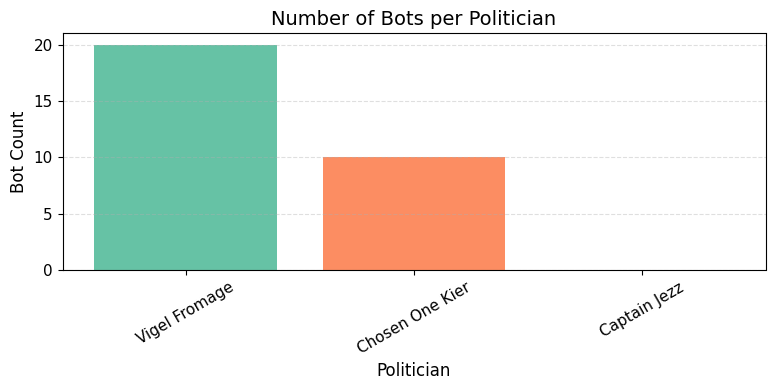

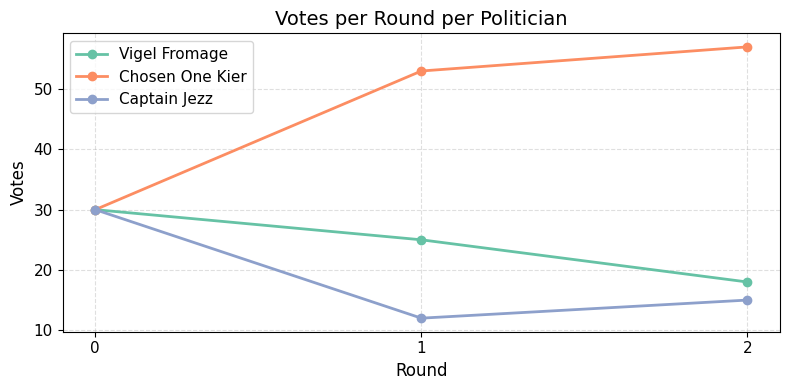

In [58]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Politicians and their bot counts
politicians = ["Vigel Fromage", "Chosen One Kier", "Captain Jezz"]
bot_counts = [20, 10, 0]

# Load voter data
if not os.path.exists("voters.csv"):
    raise FileNotFoundError("Please run this script in the folder containing voters.csv")
df = pd.read_csv("voters.csv")

# Compute vote counts for rounds 0, 1, and 2
rounds = [0, 1, 2]
votes_per_round = {}
for r in rounds:
    counts = df[f"round{r}"].value_counts()
    votes_per_round[r] = [counts.get(p, 0) for p in politicians]

# Define a pleasant color palette using matplotlib's Set2
cmap = plt.get_cmap('Set2')
colors = cmap(range(len(politicians)))

# ---- Chart 1: Bots per Politician with Custom Colors ----
plt.figure(figsize=(8, 4))
plt.bar(politicians, bot_counts, color=colors)
plt.title("Number of Bots per Politician", fontsize=14)
plt.xlabel("Politician", fontsize=12)
plt.ylabel("Bot Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

# ---- Chart 2: Votes over Rounds with Matching Colors ----
plt.figure(figsize=(8, 4))
for i, pol in enumerate(politicians):
    trend = [votes_per_round[r][i] for r in rounds]
    plt.plot(rounds, trend, marker='o', linewidth=2, label=pol, color=colors[i])

plt.title("Votes per Round per Politician", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("Votes", fontsize=12)
plt.xticks(rounds, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=11, loc="best")
plt.tight_layout()
plt.show()
